In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from funcoesTermosol import *
from pprint import pprint
import os

In [2]:
excel = pd.ExcelFile('Truss Setup.xlsx')
df_nodes = pd.read_excel(excel, 'Nodes')
df_incidences = pd.read_excel(excel, 'Elements')
df_loads = pd.read_excel(excel, 'Loads')
df_restrains = pd.read_excel(excel, 'Restrains')

In [3]:
amount_nodes = int(df_nodes.iloc[0, 3])
amount_incidence = int(df_incidences.iloc[0, 5])
amount_loads = int(df_loads.iloc[0, 4])
amount_restrains = int(df_restrains.iloc[0, 3])

df_node = df_nodes.iloc[:, 0:2].transpose()
df_incidence = df_incidences.iloc[:, 0:4]
df_load = df_loads.iloc[: , 0:3]
df_restrain = df_restrains.iloc[: , 0:2]

In [4]:
def freedom_matrix(node_amount, dimension=2):
    freedom_index = []
    for degree in range(dimension*node_amount):
        freedom_index.append(degree + 1)
    return pd.DataFrame(index=freedom_index, columns=freedom_index).fillna(0)

In [5]:
def element_load(node_idx_1, node_idx_2):
    return df_node.iloc[:2, node_idx_1 - 1], df_node.iloc[:2, node_idx_2 - 1]

def element_length(node1, node2):
    return sqrt( (node2[0] - node1[0])**2 + (node2[1] - node1[1])**2 )

def element_cos(node1, node2):
    return (node2[0] - node1[0])/element_length(node1, node2)

def element_sin(node1, node2):
    return (node2[1] - node1[1])/element_length(node1, node2)


In [6]:
def matrix_sin_cos(node_idx_1, node_idx_2):
    node1, node2 = element_load(node_idx_1, node_idx_2)
    c = element_cos(node1, node2)
    s = element_sin(node1, node2)
    freedom_index = [2*node_idx_1-1, 2*node_idx_1, 2*node_idx_2-1, 2*node_idx_2]
    data = [[  c**2,   c*s, -c**2,  -c*s],
            [   c*s,  s**2,  -c*s, -s**2],
            [ -c**2,  -c*s,  c**2,   c*s],
            [  -c*s, -s**2,   c*s,  s**2]]
    return pd.DataFrame(data, index=freedom_index, columns=freedom_index)

In [7]:
def Ke (node_idx_1, node_idx_2):
    node1, node2 = element_load(node_idx_1, node_idx_2)
    msc = matrix_sin_cos(node_idx_1, node_idx_2)
    try:
        E = df_incidence[(df_incidence['Node 1'] == node_idx_1) & (df_incidence['Node 2'] == node_idx_2)]['E [Pa]']
        A = df_incidence[(df_incidence['Node 1'] == node_idx_1) & (df_incidence['Node 2'] == node_idx_2)]['A [m²]']
    except:
        E = df_incidence[(df_incidence['Node 1'] == node_idx_2) & (df_incidence['Node 2'] == node_idx_1)]['E [Pa]']
        A = df_incidence[(df_incidence['Node 1'] == node_idx_2) & (df_incidence['Node 2'] == node_idx_1)]['A [m²]']
        
    l = element_length(node1, node2)
    return ( E.values[0]*A.values[0]/l ) * msc

In [8]:
df_freedom = freedom_matrix(amount_nodes)
df_freedom

,1,2,3,4,5,6
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0


In [9]:
df_incidence

,Node 1,Node 2,E [Pa],A [m²]
0,1,2,210000000000,0.0002
1,2,3,210000000000,0.0002
2,3,1,210000000000,0.0002


In [10]:
Ke_list = []

for element in range(amount_incidence):
    node1 = int(df_incidence.iloc[element,:].loc['Node 1'])
    node2 = int(df_incidence.iloc[element,:].loc['Node 2'])
    Ke_list.append( Ke( node1, node2 ) )

In [11]:
def overlapping(matrix1, matrix2):
    overlap = lambda v1, v2: v1 + v2
    return matrix1.combine(matrix2, overlap, overwrite=False).fillna(0)

In [12]:
df_global_rigidity = df_freedom.copy()
for df_Ke in Ke_list:
    df_global_rigidity = overlapping(df_global_rigidity, df_Ke)
df_global_rigidity

,1,2,3,4,5,6
1,30240000.0,40320000.0,0.0,0.0,-30240000.0,-40320000.0
2,40320000.0,158760000.0,0.0,0.0,-40320000.0,-53760000.0
3,0.0,0.0,140000000.0,0.0,0.0,0.0
4,0.0,0.0,0.0,105000000.0,0.0,0.0
5,-30240000.0,-40320000.0,-140000000.0,0.0,170240000.0,40320000.0
6,-40320000.0,-53760000.0,0.0,0.0,40320000.0,53760000.0


In [13]:

dimensions = 2
freedom_restrains = []
for restrain in range(amount_restrains):
    if df_restrains['1 = x               2 = y'][restrain] == 1:
        freedom_restrains.append( dimensions*df_restrain['Node'][restrain] - 1 )
    else:
        freedom_restrains.append( dimensions*df_restrain['Node'][restrain] )

print(freedom_restrains)    

[1, 3, 4]


In [14]:
new_rows = df_global_rigidity.index.difference(freedom_restrains).to_list()
new_cols = df_global_rigidity.columns.difference(freedom_restrains).to_list()
df_contours = df_global_rigidity.loc[new_cols, new_rows]
df_contours

,2,5,6
2,158760000.0,-40320000.0,-53760000.0
5,-40320000.0,170240000.0,40320000.0
6,-53760000.0,40320000.0,53760000.0


In [15]:
df_global_forces = pd.DataFrame(index=new_cols, columns=['F']).fillna(0)
dimensions = 2
for load in range(amount_loads):
    if df_load['1 = x               2 = y'][load] == 1:
        df_global_forces['F'][dimensions*df_load['Node'][load] - 1 ] = df_load['Load [N]'][load] 
    else:
        df_global_forces['F'][dimensions*df_load['Node'][load]] = df_load['Load [N]'][load]

df_global_forces

,F
2,0
5,150
6,-100


In [20]:
def solverGauss(A, b, iterations, tolerance, solution=None, method='jacobi'):
    if solution == None:
        solution = pd.DataFrame(np.zeros(b.shape))
    auxiliar = pd.DataFrame(np.zeros(solution.shape))
    temporary = pd.DataFrame(np.zeros(solution.shape))
    iteration = 0
    error = 1000
    while iteration < iterations:
        for i in range(A.shape[0]):
            x = b.iloc[i, 0]
            for j in range(A.shape[1]):
                if i != j:
                    x -= A.iloc[i, j]*solution.iloc[j, 0]
            x /= A.iloc[i, i]
            # Stores result on temporary vector to calculate the error associated with the current iteration
            temporary.iloc[i, 0] = x
            # Using 'jacobi' method the results are stored on a temporary vector:
            if method == 'jacobi':
                auxiliar.iloc[i, 0] = x
            # Using 'seidel' method the results are updated right after been calculated:
            elif method == 'seidel':
                solution.iloc[i, 0] = x
        # Using 'jacobi' method the results are updated after all values have been calculated:
        if method == 'jacobi':
            solution = auxiliar

        

        iteration += 1
        if error > tolerance:
            print("Convertion achieved after {} iterations".format(iteration))
            break


    return solution

In [21]:
df_displacement_manual = solverGauss(df_contours, df_global_forces, 1e-7, 100)
df_displacement_manual.set_index(df_global_forces.index)

Convertion achieved after 1 iterations


,0
2,0.000000e+00
5,8.811090e-07
6,-1.860119e-06


In [22]:
df_displacement = pd.DataFrame(np.linalg.solve(df_contours, df_global_forces), index=df_global_forces.index)
dimension = 2
df_displacement = df_displacement.reindex(list(range(1, dimension*amount_nodes + 1)), fill_value=0)
df_displacement

,0
1,0.000000e+00
2,-9.523810e-07
3,0.000000e+00
4,0.000000e+00
5,1.607143e-06
6,-4.017857e-06


In [23]:
def strain_on_element(node1, node2, displacement):
    n1, n2 = element_load(node1, node2)
    c = element_cos(n1, n2)
    s = element_sin(n1, n2)
    l = element_length(n1, n2)

    freedom_index = [2*node1 - 1, 2*node1, 2*node2 - 1, 2*node2]
    nodal_displacement = displacement.loc[freedom_index, :]

    data = [[-c, -s, c, s]]
    df_data = (1/l) * pd.DataFrame( data, columns=freedom_index )

    return df_data.dot(nodal_displacement).iloc[0,0]


In [24]:
print(strain_on_element(1, 2, df_displacement))
print(strain_on_element(2, 3, df_displacement))
print(strain_on_element(3, 1, df_displacement))


2.3809523809523808e-06
5.357142857142857e-06
-2.9761904761904754e-06


In [25]:
def stress_on_element(node1, node2, displacement):
    n1, n2 = element_load(node1, node2)
    c = element_cos(n1, n2)
    s = element_sin(n1, n2)
    l = element_length(n1, n2)
    try:
        E = df_incidence[(df_incidence['Node 1'] == node1) & (df_incidence['Node 2'] == node2)]['E [Pa]']
    except:
        E = df_incidence[(df_incidence['Node 1'] == node2) & (df_incidence['Node 2'] == node1)]['E [Pa]']

    freedom_index = [2*node1 - 1, 2*node1, 2*node2 - 1, 2*node2]
    nodal_displacement = displacement.loc[freedom_index, :]

    data = [[-c, -s, c, s]]
    df_data = (E.values[0]/l) * pd.DataFrame( data, columns=freedom_index )
    return df_data.dot(nodal_displacement).iloc[0,0]

In [26]:
print(stress_on_element(1, 2, df_displacement))
print(stress_on_element(2, 3, df_displacement))
print(stress_on_element(3, 1, df_displacement))

500000.0
1124999.9999999998
-624999.9999999998


In [37]:
def plot_truss(N, Inc):
    # Numero de membros
    nm = len(Inc.iloc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

#    plt.show()
    fig = plt.figure()
    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc.iloc[i,0])
        n2 = int(Inc.iloc[i,1])        
        plt.scatter([N.iloc[0, n1 - 1], N.iloc[0, n2 - 1]], [N.iloc[1, n1 - 1], N.iloc[1, n2 - 1]], color='orange')
        plt.plot([N.iloc[0, n1 - 1], N.iloc[0, n2 - 1]], [N.iloc[1, n1 - 1], N.iloc[1, n2 - 1]], color='r', linewidth=2)


    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

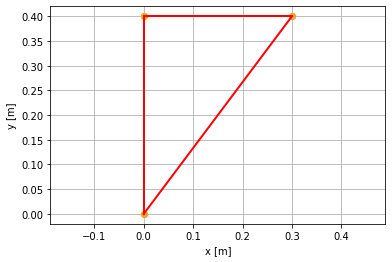

In [38]:
plot_truss(df_node, df_incidence)

In [31]:
df_node

,0,1,2
x [m],0.0,0.0,0.3
y [m],0.0,0.4,0.4
